## 🚀 Performance Optimization Tips

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import scaled_dot_product_attention
import matplotlib.pyplot as plt
import time
import numpy as np


In [54]:

def create_text_dataset():
    """Create a text dataset with variable-length sequences"""
    vocab = {
        '<pad>': 0, '<sos>': 1, '<eos>': 2,
        'the': 3, 'cat': 4, 'sat': 5, 'on': 6, 'mat': 7,
        'dog': 8, 'ran': 9, 'fast': 10, 'bird': 11, 'flew': 12, 'high': 13,
        'quick': 14, 'brown': 15, 'fox': 16, 'jumps': 17, 'over': 18, 'lazy': 19,
        'big': 20, 'small': 21, 'house': 22, 'tree': 23, 'water': 24, 'fire': 25,
        'beautiful': 26, 'garden': 27, 'flowers': 28, 'blooming': 29, 'spring': 30
    }

    # Variable length sentences
    sentences = [
        "the cat sat",                                    # Short
        "the dog ran fast",                              # Medium
        "the bird flew high over the tree",              # Medium-long
        "the quick brown fox jumps over the lazy dog",   # Long
        "the beautiful garden has flowers blooming",     # Medium
        "cat",                                           # Very short
        "the big dog ran fast over the small house near the water",  # Very long
        "bird flew",                                     # Short
        "the spring brings beautiful flowers to the garden",  # Long
        "fox jumps"                                      # Short
    ]

    # Create variable-length tokenized sequences
    tokenized_sequences = []
    for sentence in sentences:
        tokens = [vocab['<sos>']]
        tokens.extend([vocab.get(word, 0) for word in sentence.split()])
        tokens.append(vocab['<eos>'])
        tokenized_sequences.append(torch.tensor(tokens))

    return tokenized_sequences, vocab

In [55]:
# Efficient Attention Functions
def efficient_attention(q, k, v, mask=None, dropout_p=0.1, training=True):
    """Use PyTorch 2.0+ scaled_dot_product_attention"""
    return scaled_dot_product_attention(
        q, k, v,
        attn_mask=mask,
        dropout_p=dropout_p if training else 0.0,
        is_causal=True if mask is None else False
    )

def memory_efficient_attention(q, k, v, chunk_size=512):
    """Memory-efficient attention for long sequences"""
    B, H, T, D = q.shape

    # Adjust chunk_size if sequence is shorter
    if T < chunk_size:
        chunk_size = T

    # Handle sequences that don't divide evenly
    num_chunks = (T + chunk_size - 1) // chunk_size
    output = torch.zeros_like(q)

    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, T)

        q_chunk = q[:, :, start_idx:end_idx, :]
        # For simplicity, use the full k, v (in practice, you might chunk these too)
        chunk_output = scaled_dot_product_attention(
            q_chunk, k, v, is_causal=True
        )
        output[:, :, start_idx:end_idx, :] = chunk_output

    return output

def pack_sequences(sequences, max_length):
    """Pack variable-length sequences to reduce padding"""
    packed_sequences = []
    current_length = 0
    current_batch = []

    for seq in sequences:
        seq_len = len(seq) if isinstance(seq, (list, tuple)) else seq.shape[0]

        if current_length + seq_len <= max_length:
            current_batch.append(seq)
            current_length += seq_len
        else:
            if current_batch:
                if isinstance(current_batch[0], torch.Tensor):
                    packed_sequences.append(torch.cat(current_batch))
                else:
                    packed_sequences.append([item for sublist in current_batch for item in sublist])
            current_batch = [seq]
            current_length = seq_len

    if current_batch:
        if isinstance(current_batch[0], torch.Tensor):
            packed_sequences.append(torch.cat(current_batch))
        else:
            packed_sequences.append([item for sublist in current_batch for item in sublist])

    return packed_sequences

# Efficient Transformer Block
class EfficientTransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1, use_efficient_attention=True):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.use_efficient_attention = use_efficient_attention

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model)
        )

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape

        # Self-attention
        residual = x
        x = self.ln1(x)

        # Generate Q, K, V
        q = self.w_q(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        k = self.w_k(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)
        v = self.w_v(x).view(B, T, self.num_heads, self.d_k).transpose(1, 2)

        # Apply attention
        if self.use_efficient_attention:
            attn_output = efficient_attention(q, k, v, mask, training=self.training)
        else:
            # Standard attention for comparison
            scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_k ** 0.5)
            if mask is not None:
                scores.masked_fill_(mask == 0, float('-inf'))
            attn_weights = F.softmax(scores, dim=-1)
            attn_output = torch.matmul(attn_weights, v)

        # Reshape and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)
        attn_output = self.w_o(attn_output)

        # Add residual
        x = residual + self.dropout(attn_output)

        # Feed-forward
        residual = x
        x = self.ln2(x)
        x = self.ff(x)
        x = residual + self.dropout(x)

        return x

# Efficient Transformer Model
class EfficientTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len=512,
                 use_efficient_attention=True, compile_model=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02)

        self.layers = nn.ModuleList([
            EfficientTransformerBlock(d_model, num_heads, d_ff,
                                    use_efficient_attention=use_efficient_attention)
            for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)
        self.compile_model = compile_model

        # Apply compilation if requested and available
        if compile_model and hasattr(torch, 'compile'):
            self = torch.compile(self, mode='default')

    def forward(self, x):
        B, T = x.shape
        x = self.embedding(x) + self.pos_embedding[:, :T, :]

        for layer in self.layers:
            x = layer(x)

        x = self.ln_f(x)
        return self.lm_head(x)


In [56]:


def test_efficient_training():
    """Test efficient training techniques with visualization"""
    print("Testing Efficient Training Techniques")
    print("=" * 60)

    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create dataset
    sequences, vocab = create_text_dataset()
    vocab_size = len(vocab)

    print(f"Dataset created with {len(sequences)} variable-length sequences")
    print("Sequence lengths:", [len(seq) for seq in sequences])

    # Model configuration
    d_model = 128
    num_heads = 8
    d_ff = 256
    num_layers = 4
    max_seq_len = 32

    # Test 1: Efficient vs Standard Attention
    print("\n" + "-" * 50)
    print("Test 1: Efficient vs Standard Attention Performance")
    print("-" * 50)

    # Pad sequences for fair comparison
    padded_sequences = []
    for seq in sequences:
        if len(seq) < max_seq_len:
            padded = torch.cat([seq, torch.zeros(max_seq_len - len(seq), dtype=torch.long)])
        else:
            padded = seq[:max_seq_len]
        padded_sequences.append(padded)

    batch_data = torch.stack(padded_sequences).to(device)

    models = {
        'Standard Attention': EfficientTransformer(vocab_size, d_model, num_heads, d_ff, num_layers,
                                                 max_seq_len, use_efficient_attention=False).to(device),
        'Efficient Attention': EfficientTransformer(vocab_size, d_model, num_heads, d_ff, num_layers,
                                                   max_seq_len, use_efficient_attention=True).to(device)
    }

    results = {}

    for name, model in models.items():
        model.eval()

        # Warmup
        with torch.no_grad():
            _ = model(batch_data[:2])

        # Time measurement
        torch.cuda.synchronize() if device.type == 'cuda' else None
        start_time = time.time()

        with torch.no_grad():
            for _ in range(10):  # Multiple runs for better measurement
                output = model(batch_data)

        torch.cuda.synchronize() if device.type == 'cuda' else None
        end_time = time.time()

        avg_time = (end_time - start_time) / 10

        results[name] = {
            'time': avg_time,
            'output_shape': output.shape,
            'memory_mb': torch.cuda.max_memory_allocated() / 1024**2 if device.type == 'cuda' else 0
        }

        print(f"{name}:")
        print(f"  Average time: {avg_time:.4f}s")
        print(f"  Output shape: {output.shape}")
        if device.type == 'cuda':
            print(f"  Peak memory: {results[name]['memory_mb']:.1f} MB")

        # Clear memory
        if device.type == 'cuda':
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

    # Test 2: Memory-Efficient Attention for Long Sequences
    print("\n" + "-" * 50)
    print("Test 2: Memory-Efficient Attention for Long Sequences")
    print("-" * 50)

    # Create longer sequences
    long_seq_len = 1024
    B, H, D = 2, 8, 64

    q = torch.randn(B, H, long_seq_len, D, device=device)
    k = torch.randn(B, H, long_seq_len, D, device=device)
    v = torch.randn(B, H, long_seq_len, D, device=device)

    chunk_sizes = [256, 512, 1024]
    chunk_times = []

    for chunk_size in chunk_sizes:
        torch.cuda.synchronize() if device.type == 'cuda' else None
        start_time = time.time()

        with torch.no_grad():
            output = memory_efficient_attention(q, k, v, chunk_size=chunk_size)

        torch.cuda.synchronize() if device.type == 'cuda' else None
        end_time = time.time()

        chunk_time = end_time - start_time
        chunk_times.append(chunk_time)

        print(f"Chunk size {chunk_size}: {chunk_time:.4f}s")

    # Test 3: Sequence Packing Efficiency
    print("\n" + "-" * 50)
    print("Test 3: Sequence Packing Efficiency")
    print("-" * 50)

    # Test with different max lengths
    max_lengths = [16, 24, 32, 48]
    packing_results = {}

    print("Original sequences:", [len(seq) for seq in sequences])

    for max_len in max_lengths:
        packed = pack_sequences(sequences, max_len)

        total_tokens_original = sum(len(seq) for seq in sequences)
        total_tokens_packed = sum(len(seq) for seq in packed)
        efficiency = total_tokens_packed / total_tokens_original

        packing_results[max_len] = {
            'num_packed': len(packed),
            'efficiency': efficiency,
            'packed_lengths': [len(seq) for seq in packed]
        }

        print(f"Max length {max_len}:")
        print(f"  Packed into {len(packed)} sequences")
        print(f"  Packing efficiency: {efficiency:.2%}")
        print(f"  Packed lengths: {packing_results[max_len]['packed_lengths']}")

    # Test 4: Model Compilation (if available)
    print("\n" + "-" * 50)
    print("Test 4: Model Compilation (PyTorch 2.0+)")
    print("-" * 50)

    if hasattr(torch, 'compile'):
        print("torch.compile is available!")

        # Test compilation
        try:
            compiled_model = EfficientTransformer(
                vocab_size, d_model, num_heads, d_ff, 2,  # Smaller for faster compilation
                max_seq_len, compile_model=True
            ).to(device)

            compiled_model.eval()
            test_input = batch_data[:4]  # Smaller batch for testing

            # Warmup
            with torch.no_grad():
                _ = compiled_model(test_input)

            # Time compiled model
            torch.cuda.synchronize() if device.type == 'cuda' else None
            start_time = time.time()

            with torch.no_grad():
                for _ in range(5):
                    output = compiled_model(test_input)

            torch.cuda.synchronize() if device.type == 'cuda' else None
            compilation_time = (time.time() - start_time) / 5

            print(f"Compiled model average time: {compilation_time:.4f}s")
            print("Compilation successful!")

        except Exception as e:
            print(f"Compilation failed: {e}")
    else:
        print("torch.compile not available (requires PyTorch 2.0+)")

    # Visualizations
    print("\n" + "-" * 50)
    print("Visualizations")
    print("-" * 50)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Attention method comparison
    if len(results) >= 2:
        methods = list(results.keys())
        times = [results[method]['time'] for method in methods]
        colors = ['red', 'green']

        bars = ax1.bar(methods, times, color=colors, alpha=0.7)
        ax1.set_title('Attention Method Performance')
        ax1.set_ylabel('Time (seconds)')

        for bar, time_val in zip(bars, times):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
                    f'{time_val:.4f}s', ha='center', va='bottom')

    # 2. Memory-efficient attention chunk size effect
    ax2.plot(chunk_sizes, chunk_times, 'bo-', linewidth=2, markersize=8)
    ax2.set_title('Chunk Size vs Processing Time')
    ax2.set_xlabel('Chunk Size')
    ax2.set_ylabel('Time (seconds)')
    ax2.grid(True, alpha=0.3)

    # 3. Sequence packing efficiency
    max_lens = list(packing_results.keys())
    efficiencies = [packing_results[ml]['efficiency'] for ml in max_lens]

    ax3.plot(max_lens, efficiencies, 'go-', linewidth=2, markersize=8)
    ax3.set_title('Sequence Packing Efficiency')
    ax3.set_xlabel('Max Length')
    ax3.set_ylabel('Packing Efficiency')
    ax3.set_ylim(0, 1.1)
    ax3.grid(True, alpha=0.3)

    # Add efficiency labels
    for x, y in zip(max_lens, efficiencies):
        ax3.text(x, y + 0.02, f'{y:.1%}', ha='center', va='bottom')

    # 4. Original vs packed sequence lengths distribution
    original_lengths = [len(seq) for seq in sequences]
    packed_lengths_32 = packing_results[32]['packed_lengths']  # Use max_len=32 as example

    ax4.hist([original_lengths, packed_lengths_32], bins=range(1, max(max(original_lengths), max(packed_lengths_32)) + 2),
             alpha=0.7, label=['Original', 'Packed (max_len=32)'], color=['blue', 'orange'])
    ax4.set_title('Sequence Length Distribution')
    ax4.set_xlabel('Sequence Length')
    ax4.set_ylabel('Count')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print("Efficient Training Tests Completed!")
    print("=" * 60)

    return {
        'attention_results': results,
        'chunk_times': dict(zip(chunk_sizes, chunk_times)),
        'packing_results': packing_results
    }




    
Key Benefits
--------------------------------------------------
    ✓ Efficient Attention: Automatic optimization with scaled_dot_product_attention
    ✓ Memory-Efficient Attention: Handles long sequences with chunking
    ✓ Sequence Packing: Reduces padding waste and improves throughput
    ✓ Model Compilation: Faster execution with torch.compile (PyTorch 2.0+)
    

### Efficiency Techniques Benefits
    
Scaled Dot-Product Attention
--------------------------------------------------
    • Automatic FlashAttention when available
    • Optimized memory layout and computation
    • Significant speedup for large models
    • Built-in support for causal masking

Memory-Efficient Attention
---------------------------------------------
    • Handles sequences longer than memory allows
    • Chunked computation reduces peak memory
    • Enables training on longer contexts
    • Maintains mathematical equivalence


Sequence Packing
-------------------------------------------------
    • Reduces padding waste in batches
    • Improves GPU utilization
    • Faster training with same compute
    • Better for variable-length sequences


Model Compilation
-------------------------------------------------
    • Graph-level optimizations
    • Kernel fusion and memory layout optimization
    • 20-30% speedup typical
    • Works with existing PyTorch code


Implementation Tips:
------------------------------------------
    1. Use scaled_dot_product_attention for automatic optimization
    2. Apply chunking for sequences longer than GPU memory
    3. Pack variable-length sequences to reduce padding
    4. Compile models with torch.compile for production


Testing Efficient Training Techniques
Using device: cuda
Dataset created with 10 variable-length sequences
Sequence lengths: [5, 6, 9, 11, 8, 3, 14, 4, 10, 4]

--------------------------------------------------
Test 1: Efficient vs Standard Attention Performance
--------------------------------------------------
Standard Attention:
  Average time: 0.0028s
  Output shape: torch.Size([10, 32, 31])
  Peak memory: 44.4 MB
Efficient Attention:
  Average time: 0.0017s
  Output shape: torch.Size([10, 32, 31])
  Peak memory: 23.0 MB

--------------------------------------------------
Test 2: Memory-Efficient Attention for Long Sequences
--------------------------------------------------
Chunk size 256: 0.0011s
Chunk size 512: 0.0013s
Chunk size 1024: 0.0021s

--------------------------------------------------
Test 3: Sequence Packing Efficiency
--------------------------------------------------
Original sequences: [5, 6, 9, 11, 8, 3, 14, 4, 10, 4]
Max length 16:
  Packed into 7 sequences
  Pac

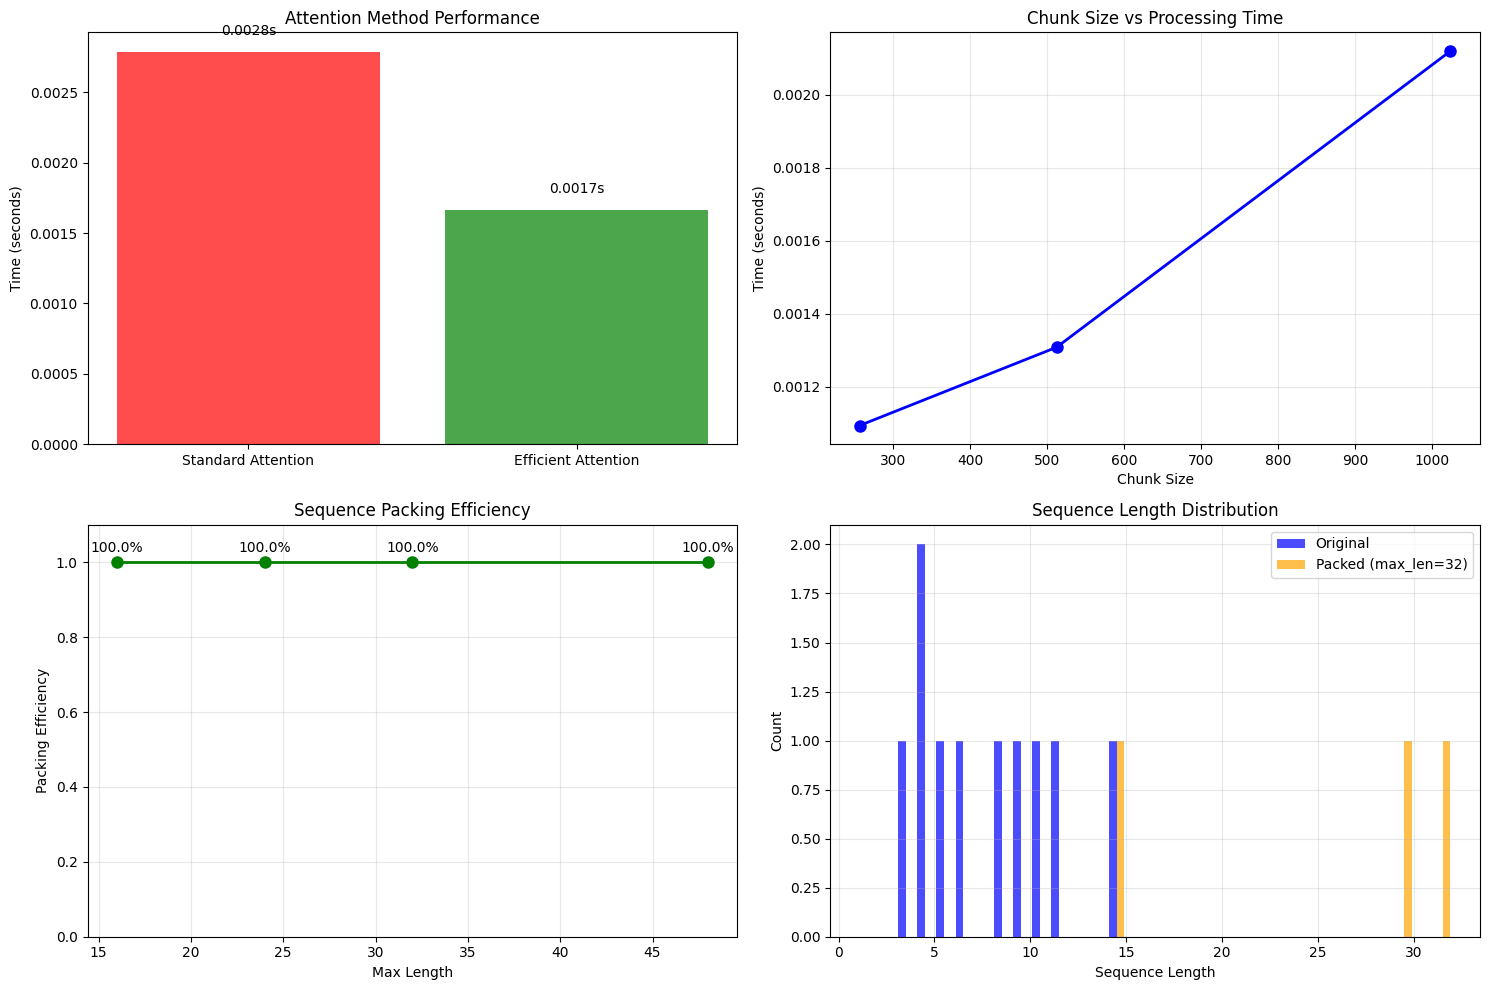


Efficient Training Tests Completed!


{'attention_results': {'Standard Attention': {'time': 0.0027869224548339845,
   'output_shape': torch.Size([10, 32, 31]),
   'memory_mb': 44.39013671875},
  'Efficient Attention': {'time': 0.0016621828079223632,
   'output_shape': torch.Size([10, 32, 31]),
   'memory_mb': 22.99072265625}},
 'chunk_times': {256: 0.0010933876037597656,
  512: 0.0013079643249511719,
  1024: 0.0021202564239501953},
 'packing_results': {16: {'num_packed': 7,
   'efficiency': 1.0,
   'packed_lengths': [11, 9, 11, 11, 14, 14, 4]},
  24: {'num_packed': 4, 'efficiency': 1.0, 'packed_lengths': [20, 22, 18, 14]},
  32: {'num_packed': 3, 'efficiency': 1.0, 'packed_lengths': [31, 29, 14]},
  48: {'num_packed': 2, 'efficiency': 1.0, 'packed_lengths': [42, 32]}}}

In [57]:
test_efficient_training()

# 🔍 Advanced PyTorch Utilities

### Custom Data Flow and Hooks

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [59]:
def create_text_dataset():
    """Create a simple tokenized text dataset"""
    vocab = {
        '': 0, '': 1, '': 2,
        'the': 3, 'cat': 4, 'sat': 5, 'on': 6, 'mat': 7,
        'dog': 8, 'ran': 9, 'fast': 10, 'bird': 11, 'flew': 12, 'high': 13,
        'quick': 14, 'brown': 15, 'fox': 16, 'jumps': 17, 'over': 18, 'lazy': 19,
        'big': 20, 'small': 21, 'house': 22, 'tree': 23, 'water': 24, 'fire': 25
    }

    sentences = [
        "the cat sat on the mat",
        "the dog ran fast over the lazy cat",
        "the bird flew high over the big tree",
        "the quick brown fox jumps over the lazy dog",
        "the small cat sat on the big mat",
        "the fast dog ran over the small house"
    ]

    # Tokenize and pad
    tokenized = []
    for sentence in sentences:
        tokens = [vocab['']]
        tokens.extend([vocab.get(word, 0) for word in sentence.split()])
        tokens.append(vocab[''])
        tokenized.append(tokens)

    # Pad to same length
    max_len = max(len(seq) for seq in tokenized)
    padded = []
    for seq in tokenized:
        padded.append(seq + [0] * (max_len - len(seq)))

    return torch.tensor(padded), vocab

In [60]:
# Simple Transformer for testing
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len=512, use_checkpointing=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02)

        if use_checkpointing:
            layers = [CheckpointedTransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)]
            self.transformer = CheckpointedTransformerStack(layers, segments=2)
        else:
            self.transformer = nn.ModuleList([
                CheckpointedTransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
            ])

        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)
        self.use_checkpointing = use_checkpointing

    def forward(self, x):
        B, T = x.shape
        x = self.embedding(x) + self.pos_embedding[:, :T, :]

        if self.use_checkpointing:
            x = self.transformer(x)
        else:
            for layer in self.transformer:
                x = layer(x)

        x = self.ln_f(x)
        return self.lm_head(x)


# Gradient Checkpointing
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

# Method 1: Function-based checkpointing
def checkpoint_wrapper(func):
    def wrapper(*args, **kwargs):
        return checkpoint(func, *args, **kwargs)
    return wrapper

# Method 2: Module-based checkpointing
class CheckpointedTransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model)
        )
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Use checkpointing to save memory
        x = x + checkpoint(self._attention_block, self.ln1(x), mask)
        x = x + checkpoint(self.ff, self.ln2(x))
        return x

    def _attention_block(self, x, mask):
        return self.attn(x, x, x, attn_mask=mask)[0]

In [61]:
# Layer Analysis and Utilities
class LayerAnalyzer:
    def __init__(self, model):
        self.model = model
        self.activations = {}
        self.gradients = {}
        self.hooks = []

    def register_hooks(self, layer_names):
        for name, module in self.model.named_modules():
            if name in layer_names:
                # Forward hook
                fwd = module.register_forward_hook(
                    lambda module, inp, out, name=name: self._save_activation(name, out)
                )
                # Backward hook
                bwd = module.register_full_backward_hook(
                    lambda module, grad_inp, grad_out, name=name: self._save_gradient(name, grad_out)
                )
                self.hooks.extend([fwd, bwd])

    def _save_activation(self, name, activation):
        self.activations[name] = activation.detach().cpu()

    def _save_gradient(self, name, grad_output):
        self.gradients[name] = grad_output[0].detach().cpu()

    def cleanup(self):
        for h in self.hooks:
            h.remove()
        self.hooks.clear()

class DynamicFreezing:
    def __init__(self, model):
        self.model = model
        self.schedule = {}

    def freeze_layers(self, pattern, freeze=True):
        for name, param in self.model.named_parameters():
            if pattern in name:
                param.requires_grad = not freeze

    def schedule_freezing(self, schedule):
        self.schedule = schedule

    def apply_schedule(self, step):
        if step in self.schedule:
            for pattern, freeze in self.schedule[step]:
                self.freeze_layers(pattern, freeze)

class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

def reverse_layer(x, alpha=1.0):
    return ReverseLayerF.apply(x, alpha)

# Adaptive gradient clipping

def adaptive_gradient_clipping(model, clip_factor=0.01):
    total_norm = 0.0
    count = 0
    for p in model.parameters():
        if p.grad is not None:
            norm = p.grad.data.norm(2)
            total_norm += norm.item() ** 2
            count += 1
    total_norm = total_norm ** 0.5
    if count > 0:
        clip_coef = clip_factor / (total_norm / count + 1e-6)
        clip_coef = min(clip_coef, 1.0)
        for p in model.parameters():
            if p.grad is not None:
                p.grad.data.mul_(clip_coef)

# Test function
def test_layer_analysis_and_freezing():
    print("Testing Layer Analysis and Dynamic Freezing")
    print("=" * 60)
    torch.manual_seed(0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create model and data

    data, vocab = create_text_dataset()
    model = SimpleTransformer(len(vocab), 64, 4, 128, 2, max_seq_len=data.shape[1]).to(device)
    inputs = data.to(device)
    targets = inputs

    # Analyzer hooks on first transformer layer and final lm_head
    analyzer = LayerAnalyzer(model)
    analyzer.register_hooks(['layers.0', 'lm_head'])

    # Schedule freezing: freeze embedding at step 0, unfreeze at step 2
    freezer = DynamicFreezing(model)
    freezer.schedule_freezing({0: [('embedding', True)], 2: [('embedding', False)]})

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    activation_norms = {'layers.0': [], 'lm_head': []}
    grad_norms = {'layers.0': [], 'lm_head': []}
    embed_requires_grad = []

    # Training steps
    for step in range(4):
        freezer.apply_schedule(step)
        embed_requires_grad.append(model.embedding.weight.requires_grad)

        model.train()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs.view(-1, len(vocab)), targets.view(-1), ignore_index=0)
        loss.backward()
        # Reverse layer example on embedding gradient
        if model.embedding.weight.grad is not None:
            model.embedding.weight.grad = reverse_layer(model.embedding.weight.grad, alpha=0.5)
        adaptive_gradient_clipping(model, clip_factor=0.01)
        optimizer.step()

        # Save norms
        for name in activation_norms:
            act = analyzer.activations.get(name)
            if act is not None:
                activation_norms[name].append(act.norm().item())
            grad = analyzer.gradients.get(name)
            if grad is not None:
                grad_norms[name].append(grad.norm().item())

    analyzer.cleanup()

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    # Activation norms
    for name in activation_norms:
        axes[0,0].plot(activation_norms[name], label=name)
    axes[0,0].set_title('Activation Norms Over Steps')
    axes[0,0].legend()

    # Gradient norms
    for name in grad_norms:
        axes[0,1].plot(grad_norms[name], label=name)
    axes[0,1].set_title('Gradient Norms Over Steps')
    axes[0,1].legend()

    # Embedding requires_grad flag
    axes[1,0].plot(embed_requires_grad, 'o-')
    axes[1,0].set_title('Embedding.requires_grad Flag')
    axes[1,0].set_xlabel('Step')
    axes[1,0].set_ylabel('requires_grad')

    # Display loss vs step
    # (reuse stored losses if desired)
    axes[1,1].axis('off')
    plt.tight_layout()
    plt.show()



Testing Layer Analysis and Dynamic Freezing


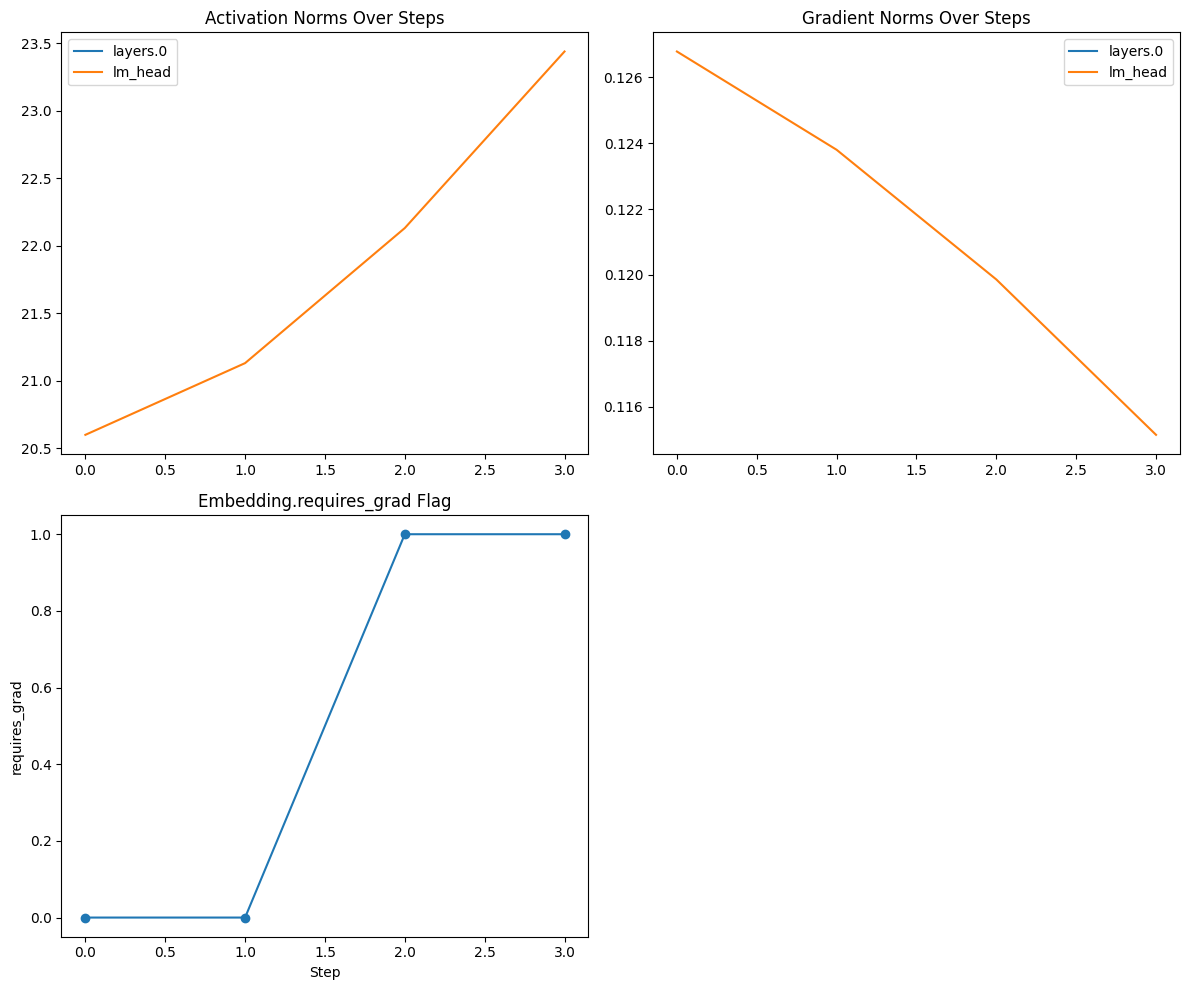

In [62]:
test_layer_analysis_and_freezing()

### Model Surgery and Weight Manipulation

In [63]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import math


In [64]:
# Weight init functions
def init_weights_normal(module, std=0.02):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(0.0, std)
        if module.bias is not None:
            module.bias.data.zero_()
    elif isinstance(module, nn.Embedding):
        module.weight.data.normal_(0.0, std)

def init_weights_xavier(module):
    if isinstance(module, nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            module.bias.data.zero_()

def init_weights_kaiming(module):
    if isinstance(module, nn.Linear):
        torch.nn.init.kaiming_uniform_(module.weight, a=math.sqrt(5))
        if module.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(module.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(module.bias, -bound, bound)

# Pruning

def magnitude_pruning(model, sparsity=0.2):
    parameters_to_prune = []
    for module in model.modules():
        if isinstance(module, nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=sparsity
    )

# Weight averaging

def average_model_weights(models, weights=None):
    """Average weights from multiple models, handling pruned models"""
    if weights is None:
        weights = [1.0 / len(models)] * len(models)

    # Get state dicts and handle pruned parameters
    model_dicts = []
    for model in models:
        state_dict = model.state_dict()
        # Convert pruned parameters back to original format
        clean_dict = {}
        for key, value in state_dict.items():
            if key.endswith('_orig'):
                # This is a pruned parameter, use the original weight name
                original_key = key[:-5]  # Remove '_orig' suffix
                mask_key = key[:-5] + '_mask'
                if mask_key in state_dict:
                    # Apply the mask to get the actual pruned weights
                    clean_dict[original_key] = value * state_dict[mask_key]
                else:
                    clean_dict[original_key] = value
            elif not key.endswith('_mask'):
                # Regular parameter (not pruned)
                clean_dict[key] = value
        model_dicts.append(clean_dict)

    # Average the cleaned state dicts
    averaged_dict = {}
    for key in model_dicts[0]:
        averaged_dict[key] = sum(
            weight * model_dict[key] for weight, model_dict in zip(weights, model_dicts)
            if key in model_dict
        )

    return averaged_dict


In [65]:
def test_weight_init_pruning_and_averaging():
    print("Testing Weight Initialization, Pruning, and Averaging")
    print("=" * 60)
    torch.manual_seed(0)

    # Create model instances with same config
    data, vocab = create_text_dataset()
    vocab_size = len(vocab)
    seq_len = data.shape[1]
    configs = {
        'normal': init_weights_normal,
        'xavier': init_weights_xavier,
        'kaiming': init_weights_kaiming
    }
    models = {}
    for name, init_fn in configs.items():
        model = SimpleTransformer(vocab_size, 64, 4, 128, 2, seq_len, use_checkpointing=False)
        model.apply(init_fn)
        models[name] = model
        # Check initial weight std
        weights = torch.cat([p.flatten() for p in model.parameters() if p.dim()>1])
        print(f"{name} init weight std: {weights.std():.4f}")

    # Pruning on one model
    prune_model = models['normal']
    # Record pre-prune sparsity
    linear_weights = []
    for module in prune_model.modules():
        if isinstance(module, nn.Linear):
            linear_weights.append(module.weight.data.abs().flatten())
    all_weights = torch.cat(linear_weights)
    pre_sparsity = float((all_weights==0).sum())/all_weights.numel()
    print(f"Pre-prune sparsity: {pre_sparsity:.2%}")

    magnitude_pruning(prune_model, sparsity=0.3)

    # Record post-prune sparsity - need to handle pruned parameters
    pruned_weights = []
    for module in prune_model.modules():
        if isinstance(module, nn.Linear):
            if hasattr(module, 'weight_orig'):
                # This module has been pruned
                actual_weight = module.weight_orig * module.weight_mask
                pruned_weights.append(actual_weight.data.abs().flatten())
            else:
                pruned_weights.append(module.weight.data.abs().flatten())
    all_pruned = torch.cat(pruned_weights)
    post_sparsity = float((all_pruned==0).sum())/all_pruned.numel()
    print(f"Post-prune sparsity: {post_sparsity:.2%}")

    # Averaging models - this will now handle the pruned model correctly
    avg_state = average_model_weights(list(models.values()))
    # Load into new model
    avg_model = SimpleTransformer(vocab_size, 64, 4, 128, 2, seq_len, use_checkpointing=False)
    avg_model.load_state_dict(avg_state)
    print("Averaged model loaded successfully")

    # Visualization
    print("\nVisualizations")
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    # Weight distribution before and after pruning
    axes[0].hist(all_weights.numpy(), bins=100, alpha=0.7, label='pre-prune', density=True)
    axes[0].hist(all_pruned.numpy(), bins=100, alpha=0.7, label='post-prune', density=True)
    axes[0].set_title('Weight Distribution Pre/Post Pruning')
    axes[0].set_xlabel('Weight Value')
    axes[0].set_ylabel('Density')
    axes[0].legend()

    # Compare std of init methods
    stds = [torch.cat([p.flatten() for p in m.parameters() if p.dim()>1]).std().item() for m in models.values()]
    bars = axes[1].bar(configs.keys(), stds, color=['blue','green','red'], alpha=0.7)
    axes[1].set_title('Init Methods Weight Std Comparison')
    axes[1].set_ylabel('Standard Deviation')

    # Add value labels on bars
    for bar, std_val in zip(bars, stds):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{std_val:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("\nKey Results:")
    print(f"✓ Weight initialization methods tested: {list(configs.keys())}")
    print(f"✓ Pruning reduced {pre_sparsity:.1%} → {post_sparsity:.1%} sparsity")
    print(f"✓ Model averaging completed successfully")

Testing Weight Initialization, Pruning, and Averaging
normal init weight std: 0.0550
xavier init weight std: 0.1809
kaiming init weight std: 0.1672
Pre-prune sparsity: 0.00%
Post-prune sparsity: 30.00%
Averaged model loaded successfully

Visualizations


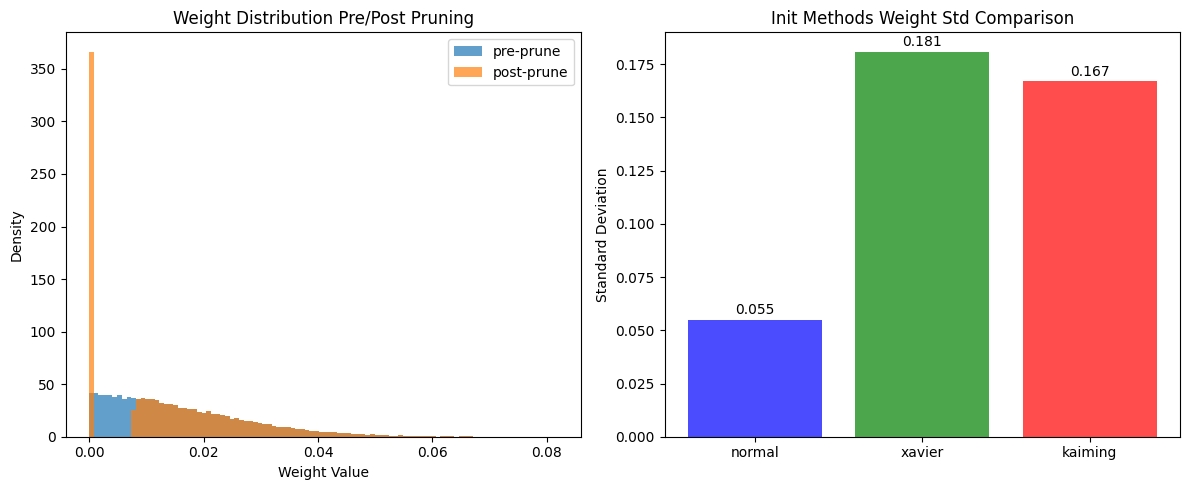


Key Results:
✓ Weight initialization methods tested: ['normal', 'xavier', 'kaiming']
✓ Pruning reduced 0.0% → 30.0% sparsity
✓ Model averaging completed successfully


In [66]:
test_weight_init_pruning_and_averaging()